# **Airbnb Hotel Booking Analysis**
## Problem Statement

The goal of this project is to analyze Airbnb booking/listings data to uncover insights that help hosts optimize pricing and listing strategies and enhance guest satisfaction. This notebook performs data cleaning, exploratory data analysis (EDA), visualization, and draws recommendations.

---


In [2]:

# Setup: imports and helper functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

def clean_price_series(s):
    return pd.to_numeric(s.astype(str).str.replace(r'[\$,]', '', regex=True).str.strip().replace({'': None, 'nan': None}), errors='coerce')

print('Ready')

Ready


In [4]:
# Load dataset
file_path = '1730285881-Airbnb_Open_Data.xlsx'
xls = pd.ExcelFile(file_path)
print('Available sheets:', xls.sheet_names)
df = pd.read_excel(xls, sheet_name=0)
print('Loaded shape:', df.shape)
df.head()

Available sheets: ['in']
Loaded shape: (102599, 26)


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,124.0,3.0,0.0,NaT,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,74.0,30.0,270.0,2019-07-05,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [5]:
# Quick info and column list
df.info()
print('\nColumns:\n', df.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   id                              102599 non-null  int64         
 1   NAME                            102329 non-null  object        
 2   host id                         102599 non-null  int64         
 3   host_identity_verified          102310 non-null  object        
 4   host name                       102191 non-null  object        
 5   neighbourhood group             102570 non-null  object        
 6   neighbourhood                   102583 non-null  object        
 7   lat                             102591 non-null  float64       
 8   long                            102591 non-null  float64       
 9   country                         102067 non-null  object        
 10  country code                    102468 non-null  object 

In [6]:
# Cleaning common columns
data = df.copy()

# Detect common columns
price_cols = [c for c in data.columns if 'price' in c.lower()]
neigh_cols = [c for c in data.columns if 'neighbour' in c.lower() or 'neigh' in c.lower() or 'neighborhood' in c.lower()]
room_cols = [c for c in data.columns if 'room' in c.lower() and 'type' in c.lower()]
reviews_cols = [c for c in data.columns if 'number_of_reviews' in c.lower() or 'num_reviews' in c.lower() or 'reviews'==c.lower() or 'reviews' in c.lower()]
host_cols = [c for c in data.columns if 'host' in c.lower()]
service_cols = [c for c in data.columns if 'service' in c.lower() and 'fee' in c.lower()]

print('Detected: price-like', price_cols)
print('Detected: neighbourhood-like', neigh_cols)
print('Detected: room type-like', room_cols)
print('Detected: reviews-like', reviews_cols[:5])
print('Detected: host-like', host_cols[:5])
print('Detected: service-like', service_cols)

# Clean price if exists
if price_cols:
    price_col = price_cols[0]
    data['price_clean'] = clean_price_series(data[price_col])
    print('Cleaned price column -> price_clean')
else:
    price_col = None
    print('No price column detected')

# Numeric reviews
num_reviews_col = None
for c in data.columns:
    if 'number_of_reviews' in c.lower() or 'num_reviews' in c.lower():
        num_reviews_col = c
        break
if not num_reviews_col:
    for c in data.columns:
        if 'review' in c.lower() and np.issubdtype(data[c].dtype, np.number):
            num_reviews_col = c
            break
if num_reviews_col:
    data['num_reviews_clean'] = pd.to_numeric(data[num_reviews_col], errors='coerce')
    print('Using reviews column ->', num_reviews_col)
else:
    print('No numeric reviews column detected')

# show sample
data[[c for c in [price_col, 'price_clean', num_reviews_col] if c in data.columns]].head()

Detected: price-like ['price']
Detected: neighbourhood-like ['neighbourhood group', 'neighbourhood']
Detected: room type-like ['room type']
Detected: reviews-like ['number of reviews', 'reviews per month']
Detected: host-like ['host id', 'host_identity_verified', 'host name', 'calculated host listings count']
Detected: service-like ['service fee']
Cleaned price column -> price_clean
Using reviews column -> number of reviews


,price,price_clean,number of reviews
0,966.0,966.0,9.0
1,142.0,142.0,45.0
2,620.0,620.0,0.0
3,368.0,368.0,270.0
4,204.0,204.0,9.0


In [7]:
# EDA: Property / Room Types
# detect room/property column
room_col = None
for c in data.columns:
    if c.lower() in ('room_type','property_type') or ('room' in c.lower() and 'type' in c.lower()):
        room_col = c
        break

if room_col:
    print('Room/property column:', room_col)
    display(data[room_col].value_counts().head(20))
else:
    print('No room/property column found')

# Top neighborhoods by listing count
neigh_col = None
for c in data.columns:
    if c.lower() in ('neighbourhood_group','neighborhood_group','neighbourhood','neighborhood','neighbourhood_group_cleansed'):
        neigh_col = c
        break

if neigh_col:
    print('Neighbourhood column:', neigh_col)
    top_neigh = data[neigh_col].astype(str).value_counts().head(20)
    display(top_neigh)
    # average price by neighbourhood
    if 'price_clean' in data.columns:
        avg_price_neigh = data.groupby(neigh_col)['price_clean'].mean().sort_values(ascending=False).head(20)
        display(avg_price_neigh)
else:
    print('No neighbourhood-like column detected')

Room/property column: room type


room type
Entire home/apt    53701
Private room       46556
Shared room         2226
Hotel room           116
Name: count, dtype: int64

Neighbourhood column: neighbourhood


neighbourhood
Bedford-Stuyvesant    7937
Williamsburg          7775
Harlem                5466
Bushwick              4982
Hell's Kitchen        3965
Upper West Side       3860
Upper East Side       3680
East Village          3492
Midtown               3390
Crown Heights         3262
East Harlem           2341
Chelsea               2285
Greenpoint            2143
Lower East Side       1948
Astoria               1876
Washington Heights    1779
Financial District    1490
West Village          1484
Flatbush              1295
East Flatbush         1211
Name: count, dtype: int64

neighbourhood
New Dorp                  1045.000000
Chelsea, Staten Island    1042.000000
Fort Wadsworth            1024.000000
Little Neck                817.750000
Jamaica Hills              812.904762
Arden Heights              804.888889
Midland Beach              796.176471
Shore Acres                792.260870
Mill Basin                 775.142857
Riverdale                  768.736842
East Morrisania            764.666667
Morris Heights             742.891304
Pelham Bay                 740.045455
North Riverdale            736.250000
Graniteville               732.571429
Bath Beach                 725.270833
Columbia St                716.662921
Eltingville                712.000000
Woodrow                    709.333333
Todt Hill                  707.000000
Name: price_clean, dtype: float64

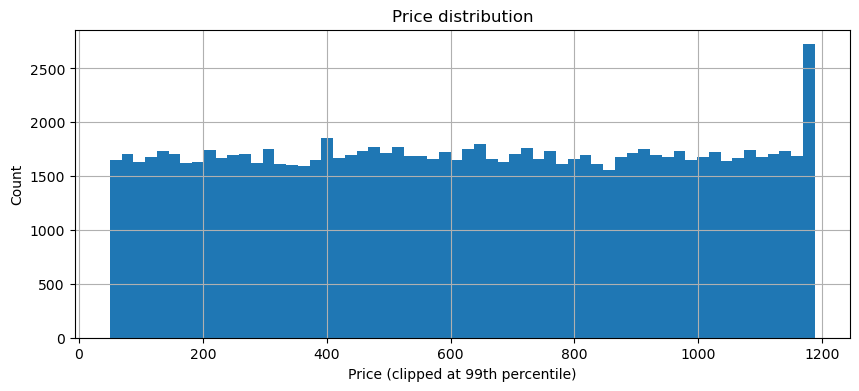

In [8]:
# Price distribution
import matplotlib.pyplot as plt
if 'price_clean' in data.columns:
    plt.figure(figsize=(10,4))
    data['price_clean'].dropna().clip(upper=data['price_clean'].quantile(0.99)).hist(bins=60)
    plt.xlabel('Price (clipped at 99th percentile)')
    plt.ylabel('Count')
    plt.title('Price distribution')
    plt.show()
else:
    print('No price column to plot')

Correlation: 0.005229248273116563


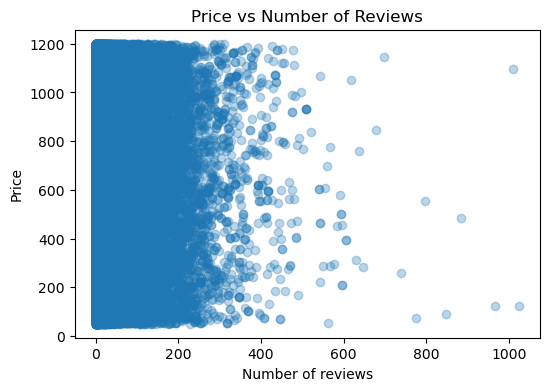

In [9]:
# Price vs Number of Reviews
if 'price_clean' in data.columns and 'num_reviews_clean' in data.columns:
    print('Correlation:', data['price_clean'].corr(data['num_reviews_clean']))
    plt.figure(figsize=(6,4))
    plt.scatter(data['num_reviews_clean'], data['price_clean'], alpha=0.3)
    plt.xlabel('Number of reviews')
    plt.ylabel('Price')
    plt.title('Price vs Number of Reviews')
    plt.show()
else:
    print('Missing price or reviews for this analysis')

In [10]:
# Top hosts by listing count
host_id_col = None
host_name_col = None
for c in data.columns:
    if c.lower() in ('host_id','host id','hostid'):
        host_id_col = c
    if c.lower() in ('host_name','host name'):
        host_name_col = c

# fallback: any column containing 'host' for id
if not host_id_col:
    for c in data.columns:
        if 'host' in c.lower() and np.issubdtype(data[c].dtype, np.number):
            host_id_col = c
            break

if host_id_col:
    top_hosts = data[host_id_col].value_counts().head(10).rename_axis('host_id').reset_index(name='listing_count')
    if host_name_col:
        name_map = data.drop_duplicates(subset=host_id_col).set_index(host_id_col)[host_name_col].to_dict()
        top_hosts['host_name'] = top_hosts['host_id'].map(name_map)
    display(top_hosts)
else:
    print('No host id column detected')

,host_id,listing_count,host_name
0,38729751923,2,Dominque
1,3895711649,2,Mifan
2,43698780331,2,Etkin
3,83121548580,2,Francisco
4,95831271296,2,Boris
5,22326090286,2,Irving
6,33983881137,2,Jayanthi
7,59240106692,2,Elena
8,31012769204,2,Jonathan
9,60627453207,2,Monica


In [11]:
# Verified host identity vs avg reviews
verified_col = None
for c in data.columns:
    if 'identity' in c.lower() and 'verified' in c.lower():
        verified_col = c
        break

if verified_col and 'num_reviews_clean' in data.columns:
    grp = data.groupby(data[verified_col].astype(str))['num_reviews_clean'].mean().reset_index().rename(columns={'num_reviews_clean':'avg_reviews'})
    display(grp)
else:
    print('Cannot analyze verified identity vs reviews (missing columns)')

,host_identity_verified,avg_reviews
0,nan,46.266436
1,unconfirmed,27.541759
2,verified,27.319199


Correlation: 0.9999908755543334


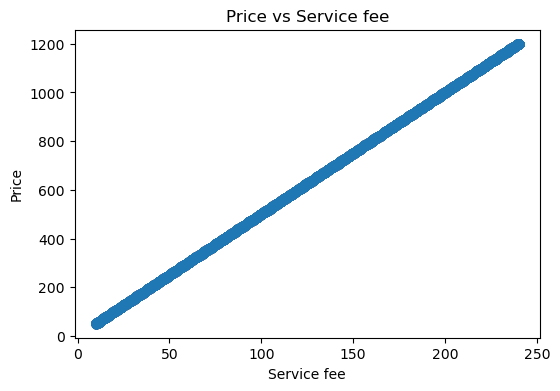

In [12]:
# Price vs service fee
service_col = None
for c in data.columns:
    if 'service' in c.lower() and 'fee' in c.lower():
        service_col = c
        break

if service_col and 'price_clean' in data.columns:
    data['service_clean'] = clean_price_series(data[service_col])
    print('Correlation:', data['price_clean'].corr(data['service_clean']))
    plt.figure(figsize=(6,4))
    plt.scatter(data['service_clean'], data['price_clean'], alpha=0.3)
    plt.xlabel('Service fee')
    plt.ylabel('Price')
    plt.title('Price vs Service fee')
    plt.show()
else:
    print('No service fee or price column available to compare')

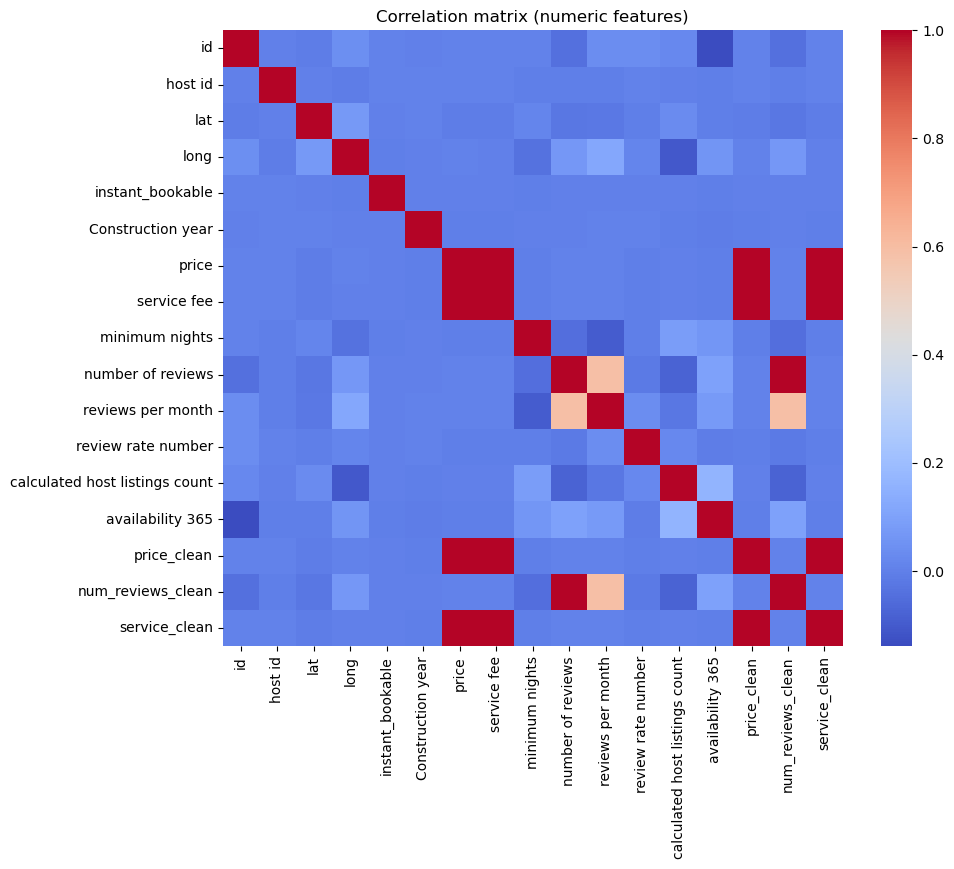

In [13]:
# Correlation heatmap for numeric columns
import seaborn as sns
num_df = data.select_dtypes(include=[np.number]).copy()
if not num_df.empty:
    corr = num_df.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation matrix (numeric features)')
    plt.show()
else:
    print('No numeric columns for correlation matrix')